<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 1: Sem2 AY 23/24 - Convolutational Neural Networks (CNNs)

Module Leader: J.J. Collins

Students:  
- Siddharth Prince - 23052058
- Pratik Verma - 23007575

---
## Code checks
### Test cases
 - Imports and setup - <span style='color: #0e0'>Pass</span>
 - Data preprocessing and EDA - <span style='color:orange'>waiting</span></li>
 - CNN architecture definition - <span style='color:orange'>waiting</span>
 - Training - <span style='color:orange'>waiting</span>
 - Testing - <span style='color:orange'>waiting</span>
 - Metrics and evalutation - <span style='color:orange'>waiting</span>
 - Finetuning model - <span style='color:orange'>waiting</span>
 - Engineering over-fitting/under-fitting - <span style='color:orange'>waiting</span>
---

## References
- [Sample Kaggle implementation with the Caltech-101 dataset](https://www.kaggle.com/code/ahmeddheyaa/caltech-101-image-classification/notebook)
- [Activity-6 notebook submission from semester 1 for module CE4051-Introduction to Data Engineering and Machine Learning by Siddharth Prince (23052058)](https://github.com/sprince0031/UL_Masters/blob/main/SEM_1/CE4051-Introduction_to_Data_Engineering_and_Machine_Learning/Week11_12/Activity6_23052058.ipynb)
- [Pytorch Alexnet sample](https://pytorch.org/hub/pytorch_vision_alexnet/)
- [Alexnet architecture code reference](https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py)

## 1. Imports and setup

In [45]:
import torch
from torch import nn # Importing torch's neural network (nn) class
import torch.nn.functional as F # importing this separately as 'F' to save the hasle of typing all that out. Also, it's funny.
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import Caltech101
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
from torchvision import models

import matplotlib.pyplot as plt # Old faithful for plotting
import matplotlib.ticker as ticker
import numpy as np # It isn't a jupyter notebook running ML models without numpy, is it?
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import os
import time
from imutils import paths

import warnings 
warnings.filterwarnings('ignore') # To ignore the big red future warnings (we'll change our ways when things break and not premtively. 'Tis human nature.)

torch.manual_seed(69) # Setting a manual seed for consistency

In [2]:
# Pytorch version
torch.__version__

'2.2.1+cu121'

In [3]:
# Global variables
ROOT_DIR = './datasets/'
EPOCHS = 10
BATCH_SIZE = 16

### Selecting the device to use

In [4]:
# Get appropriate device for training
device = ( "cuda"     # CUDA to take advantage of Nvidia GPUs
           if torch.cuda.is_available()
           else "cpu" )   # If this fails -> CPU. Will probably use Google Colab and get a GPU.

print(f"{device} device available")

cuda device available


## 2. Data preprocessing and EDA

Below, we tried to compute the mean and standard deviation for the dataset based on the sample reference from a [pytorch forum thread](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/12). But, it turned out that the Caltech-101 dataset does not support this straightforward implementation because of a lack of test and train splits within the dataset iteself. Instead of going out of our way to do this again and re-invent the wheel, we decided to do what everyone else does and use the precomputed values of the ImageNet from the example implementations which seems to be widely accepted as the gold standard. [Reference](https://stackoverflow.com/a/57533806/5584011)

In [ ]:
temp_transform = transforms.Compose([transforms.ToTensor()])
caltech101_data = Caltech101(root=root_dir, download=True, transform=temp_transform)


'''
The following code results in an error since the Caltech-101 dataset does not come with a partitioned training and testing set 
unlike other datasets such as CIFAR and MNIST.

mean = caltech101_data.train_data.mean(axis=(0,1,2))/255
std = mean = caltech101_data.train_data.std(axis=(0,1,2))/255
print(f'Mean values across the 3 colour channels for the Caltech101 data are {mean}')
print(f'Standard deviation values across the 3 colour channels for the Caltech101 data are {std}')
'''

In [5]:
# Downloading the Caltech-101 dataset from the torch datasets library

caltech101_data = Caltech101(root='./datasets/', download=True)
data_loader = DataLoader(caltech101_data, # Loading the data into pytorch's Dataloader which is an iterable object making it easy to access the data
                         batch_size=16, # Defining the size for each batch
                         shuffle=True) # Shuffling the images before getting batched to remove any possible biases occoring from the order of the dataset

Files already downloaded and verified


In [23]:
image_paths = list(paths.list_images(f'{ROOT_DIR}caltech101/101_ObjectCategories'))
print(image_paths[:5])

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2] # Taking the name of the image folder in the path to be the label
    if label == "BACKGROUND_Google": # We're leaving this category out because it's just random background images
        continue
    img = cv2.imread(img_path) # Reads the images at each of the image paths
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converts the colour channels from BGR to RGB

    # Here, we're just appending all the images and their corresponding labels to the same index number in two separate lists
    data.append(np.array(img))
    labels.append(label)

# Converting the lists to numpy arrays for better manupilation
data_np = np.array(data)
labels = np.array(labels)

['./datasets/caltech101/101_ObjectCategories/crayfish/image_0026.jpg', './datasets/caltech101/101_ObjectCategories/crayfish/image_0016.jpg', './datasets/caltech101/101_ObjectCategories/crayfish/image_0014.jpg', './datasets/caltech101/101_ObjectCategories/crayfish/image_0046.jpg', './datasets/caltech101/101_ObjectCategories/crayfish/image_0048.jpg']


100%|█████████████████████████████████████| 9144/9144 [00:09<00:00, 1002.04it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8677,) + inhomogeneous part.

In [24]:
print(len(data))

8677


In [10]:
print(len(data[0]))
print(len(data[1]))
print(length)

170
292
494


In [31]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")

Total number of classes: 101


In [49]:
label_list = lb.inverse_transform(labels)
print(label_list[:5])

['crayfish' 'crayfish' 'crayfish' 'crayfish' 'crayfish']


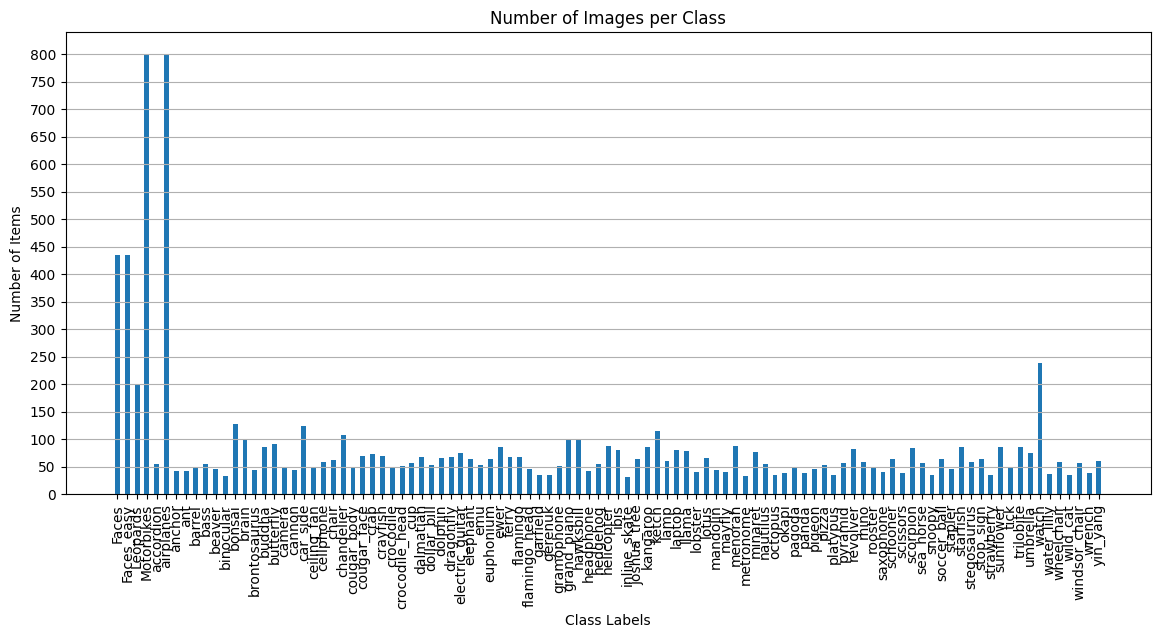

In [46]:
# Plotting a graph of the data distribution for each of the classes
labelCounts = labels.sum(axis=0)
plt.figure(figsize=(14, 6))
plt.bar(lb.classes_, labelCounts, width=0.5)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.xlabel('Class Labels')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Items')
plt.title('Number of Images per Class')
plt.grid(axis='y')
plt.show()

In [26]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [20]:
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)
# print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

AttributeError: 'list' object has no attribute 'shape'

In [22]:
x_train = np.array(x_train)

ValueError: maximum supported dimension for an ndarray is 32, found 5205

In [27]:
# custom dataset
class ImageDataset(TensorDataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [28]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [52]:
print(text_labels)

{'crayfish': 69, 'butterfly': 160, 'brontosaurus': 203, 'ant': 245, 'minaret': 321, 'binocular': 354, 'llama': 432, 'grand_piano': 531, 'platypus': 565, 'emu': 618, 'metronome': 650, 'pagoda': 697, 'saxophone': 737, 'brain': 835, 'snoopy': 870, 'ferry': 937, 'schooner': 1000, 'headphone': 1042, 'anchor': 1084, 'umbrella': 1159, 'elephant': 1223, 'hawksbill': 1323, 'wheelchair': 1382, 'Motorbikes': 2180, 'pizza': 2233, 'crocodile': 2283, 'accordion': 2338, 'joshua_tree': 2402, 'ibis': 2482, 'dalmatian': 2549, 'helicopter': 2637, 'crab': 2710, 'cannon': 2753, 'car_side': 2876, 'sunflower': 2961, 'cougar_body': 3008, 'lamp': 3069, 'wild_cat': 3103, 'garfield': 3137, 'stegosaurus': 3196, 'euphonium': 3260, 'gerenuk': 3294, 'windsor_chair': 3350, 'soccer_ball': 3414, 'flamingo': 3481, 'lotus': 3547, 'scorpion': 3631, 'dollar_bill': 3683, 'panda': 3721, 'chair': 3783, 'trilobite': 3869, 'stapler': 3914, 'lobster': 3955, 'rhino': 4014, 'barrel': 4061, 'ewer': 4146, 'mandolin': 4189, 'beaver':

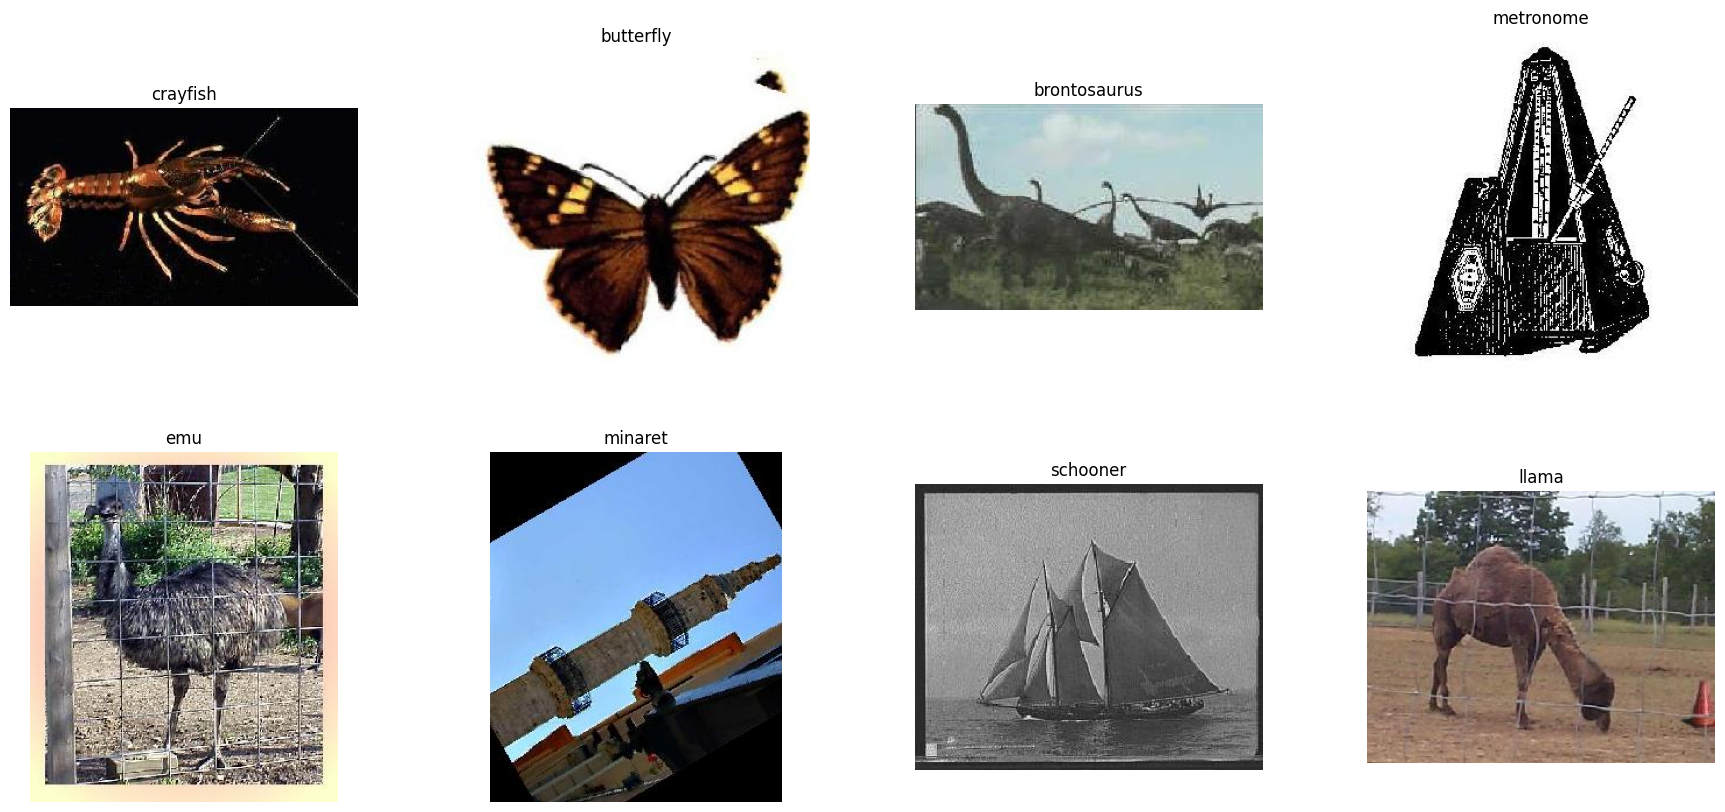

In [57]:
# visualising the some of the images
# Displaying a few examples of he dataset to ensure they have been loaded correctly.
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.subplots_adjust(wspace=0.3)
ax = ax.flatten()
exampleItems = [0, 123, 187, 647, 569, 298, 1000, 420]
for i in range(8):
    ax[i].imshow(data[exampleItems[i]], cmap='gray')
    ax[i].axis('off')  # clear x-axis and y-axis
    ax[i].set_title(label_list[exampleItems[i]])

plt.show()

## 3. CNN

In [29]:
# the resnet34 model
class Alexnet(nn.Module):
    def __init__(self, pretrained):
        super(Alexnet, self).__init__()
        if pretrained is True:
            self.model = models.alexnet()
        else:
            self.model = models.alexnet(weights=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
model = Alexnet(pretrained=True).to(device)

NameError: name 'pretrainedmodels' is not defined

In [47]:
# Code reference: https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=1000):
        """
        Define and allocate layers for this neural net.

        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        # input size should be : (b x 3 x 227 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x):
        """
        Pass the input through the net.

        Args:
            x (Tensor): input tensor

        Returns:
            output (Tensor): output tensor
        """
        x = self.net(x)
        x = x.view(-1, 256 * 6 * 6)  # reduce the dimensions for linear layer input
        return self.classifier(x)

## 4. Training

In [48]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it
        
        optimizer.zero_grad()               #<--- what is this for?
        
        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

